In [120]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

C:\Users\Pablo\AppData\Local\Temp\ipykernel_7928\2026922495.py:6: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


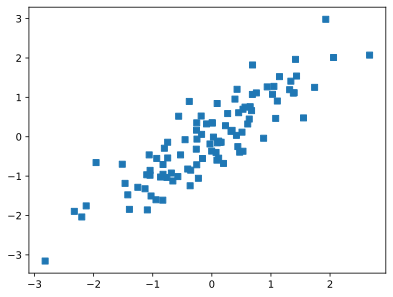

In [121]:
# create data
torch.manual_seed(19)
N = 100 # the more points the higher the optimized loss will be, 
# since the model will have to account for more data points to the loss

x = torch.randn(N, 1)
y = x + torch.randn(N, 1) * 0.5

# plot data
plt.plot(x, y, "s")
plt.show()

In [ ]:
ANNreg = nn.Sequential(
    nn.Linear(1, 1), # input layer with 1 neuron and output layer with 1 neuron
    nn.ReLU(), # activation function
    nn.Linear(1, 1) # output layer with 1 neuron
) # Pls note that there is no sigmoid since it is a regression problem.
# the function of the last linear layer is to transform the output of the previous 
# layer to the desired output shape, in this case, 1 neuron. But sometimes the output 
# of the previous layer is higher therefore we need this last layer to return 1 value

ANNreg

Sequential(
  (0): Linear(in_features=1, out_features=1, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1, out_features=1, bias=True)
)

In [123]:
learning_rate = 0.05
criterion = nn.MSELoss() # mean squared error loss function since we are doing regression

# create optimizer, in this case we are using stochastic gradient descent (SGD) optimizer
# which is a simple optimization algorithm that updates the model parameters in the direction 
# of the negative gradient of the loss function with respect to the parameters. 
optimizer = torch.optim.SGD(ANNreg.parameters(), lr=learning_rate)

In [124]:
# training loop
n_epochs = 500
losses = torch.zeros(n_epochs)

for epoch in range(n_epochs):
    # forward pass
    y_pred = ANNreg( x)

    # compute loss
    loss = criterion(y_pred, y)
    losses[epoch] = loss.item()
    
    # backward propagation
    optimizer.zero_grad() # zero the gradients before backward pass.
    # If we don't do this, the gradients will be accumulated from the previous iterations.
    loss.backward() # compute the gradients
    optimizer.step() # update the parameters

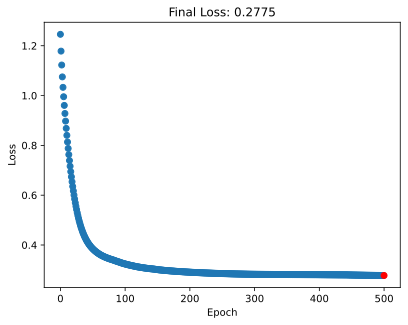

In [125]:
predictions = ANNreg(x)
testloss = (predictions - y).pow(2).mean()

# or

testloss = criterion(ANNreg(x), y) # compute the test loss and detach it from the computation graph


plt.plot(losses, "o")
plt.plot(n_epochs, testloss.detach(), "ro") # detach is used to convert the tensor to a scalar
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Final Loss: {:.4f}".format(testloss.item()))
plt.show()

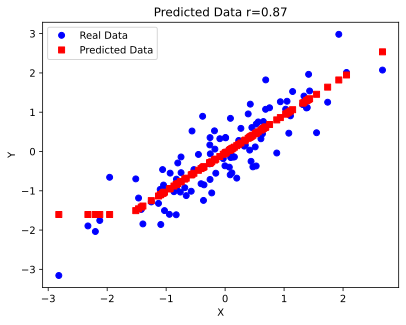

In [126]:
# we can see that the predicted data is curved, 
# this is because of the ReLU activation function, which is a non-linear 
# function that allows the model to learn non-linear relationships between 
# the input and output data. 
plt.plot(x, y, "bo", label="Real Data")
plt.plot(x, ANNreg(x).detach(), "rs", label="Predicted Data")
plt.xlabel("X")
plt.ylabel("Y")
plt.title(f"Predicted Data r={np.corrcoef(y.T, ANNreg(x).detach().T)[0, 1]:.2f}")
plt.legend()
plt.show()

In [127]:
# We can also create a function to build the model and a function to train the model

def build_model(input_size, output_size):
    model = nn.Sequential(
        nn.Linear(input_size, 1), 
        nn.ReLU(), 
        nn.Linear(1, output_size) 
    )
    return model

def train_model(model, x, y, n_epochs=500, learning_rate=0.05):
    criterion = nn.MSELoss() 
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    losses = torch.zeros(n_epochs)

    for epoch in range(n_epochs):
        # forward pass
        y_pred = model(x)

        # compute loss
        loss = criterion(y_pred, y)
        losses[epoch] = loss.item()
        
        # backward propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return losses 

def create_data(slope, N=100, random_seed=19): 
    torch.manual_seed(random_seed)
    x = torch.randn(N, 1)
    y = slope*x + torch.randn(N, 1) * 0.5
    return x, y

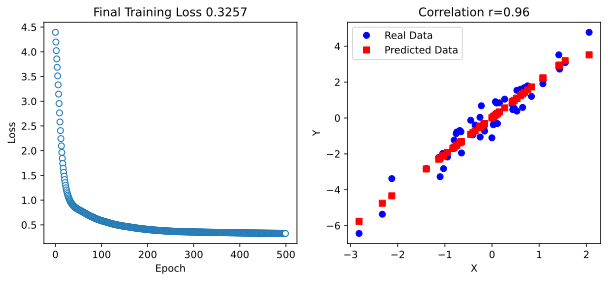

In [ ]:
x, y = create_data(slope=2, N=50, random_seed=19)
model = build_model(input_size=1, output_size=1)
losses = train_model(model, x, y, n_epochs=500, learning_rate=0.05)
y_pred = model(x)


# Sometimes the predicted data could be an horizontal line, this is
# because the model is not learning the relationship between the input and output data,
# this could be the result of the gradient falling into a local minima.
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(losses, "o", markerfacecolor="w")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].set_title(f"Final Training Loss {losses[-1]:.4f}")

ax[1].plot(x, y, "bo", label="Real Data")
ax[1].plot(x, y_pred.detach(), "rs", label="Predicted Data")
ax[1].set_xlabel("X")
ax[1].set_ylabel("Y")
ax[1].set_title(f"Correlation r={np.corrcoef(y.T, y_pred.detach().T)[0, 1]:.2f}")
ax[1].legend()

In [135]:
# slops to simulate
slopes = np.linspace(-2, 2, 21)
numExps = 50 # number of experiments to run for each slope
results = np.zeros((len(slopes), numExps, 2))

for slope_idx, slope in enumerate(slopes):
    for exp in range(numExps):
        x, y = create_data(slope=slope, N=50, random_seed=exp)
        model = build_model(input_size=1, output_size=1)
        losses = train_model(model, x, y, n_epochs=500, learning_rate=0.05)
        y_pred = model(x)
        results[slope_idx, exp, 0] = losses[-1] # we just store the final training loss
        results[slope_idx, exp, 1] = np.corrcoef(y.T, y_pred.detach().T)[0, 1]

# correlation can be 0 if the model didn't do well:
results[np.isnan(results)] = 0

d:\Pablo_Data\Documentos\VSCode\deep-learning\venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3023: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
d:\Pablo_Data\Documentos\VSCode\deep-learning\venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3024: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


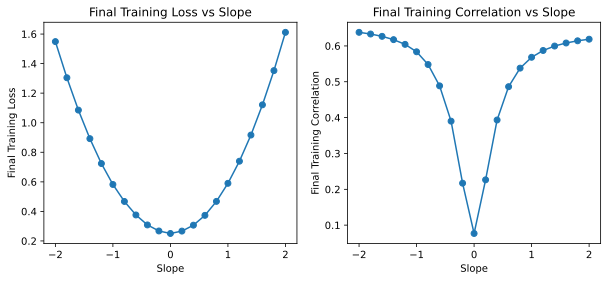

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(slopes, results[:, :, 0].mean(axis=1), "o-")
ax[0].set_xlabel("Slope")
ax[0].set_ylabel("Final Training Loss")
ax[0].set_title("Final Training Loss vs Slope")

ax[1].plot(slopes, results[:, :, 1].mean(axis=1), "o-")
ax[1].set_xlabel("Slope")
ax[1].set_ylabel("Final Training Correlation")
ax[1].set_title("Final Training Correlation vs Slope")
plt.show()
# Explanation below

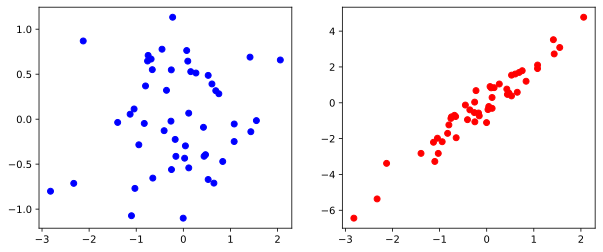

In [ ]:
# The explanaition behind the first graph:
# Losses are not normalized, they are in the scale of the data. Larger slopes led to more variance in y.
x1, y1 = create_data(slope=0, N=50, random_seed=19)
x2, y2 = create_data(slope=2, N=50, random_seed=19)
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(x1, y1, "bo", label="Slope 0")
ax[1].plot(x2, y2, "ro", label="Slope 2")

# Losses can only be compared on the same data, or on different datasets that are normalized
# to the the same numeric range

In [ ]:
# The explanaition behind the second graph:
# x is less informative when the slope is 0, therefore the model has a harder 
# time learning the relationship between x and y, which leads to a higher training 
# loss and a lower correlation.

# ANNs dont predict values, they learn the relationship between the input and output data,